In this task, I used tweet-eval dataset which include 11 subsets framed as a multi-class tweet classification. [Here you can see the dataset summary](https://huggingface.co/datasets/tweet_eval). I used three subsets for data exploration and skipped other subsets since same analysis can be done on the others.

In [ ]:
!pip install datasets


In [ ]:
!pip install -U huggingface_hub

In [ ]:
from datasets import  load_dataset
import pandas as pd
import matplotlib.pyplot as plt

# Downloading and loading a dataset
df_offensive = pd.DataFrame(load_dataset('tweet_eval', 'offensive' )['train'])
df_feminist = pd.DataFrame(load_dataset('tweet_eval', 'stance_feminist' )['train'])
# df_atheism = pd.DataFrame(load_dataset('tweet_eval', 'stance_atheism' )['train'])
# df_hillary = pd.DataFrame(load_dataset('tweet_eval', 'stance_hillary' )['train'])
df_abortion = pd.DataFrame(load_dataset('tweet_eval', 'stance_abortion' )['train'])
df_emotion = pd.DataFrame(load_dataset('tweet_eval', 'emotion' )['train'])
df_emoji = pd.DataFrame(load_dataset('tweet_eval', 'emoji' )['train'])


In [143]:
df = [df_emoji, df_abortion, df_emotion, df_feminist, df_offensive]

First we check if there is any Nan item inside the dataset

In [16]:
for item in df:
  if item['text'].isnull().any() == True:
    print(item.isnull().sum())


Now let's take a look at 
one of the datasets. Regarding the text part we can see the word "@user" is used in almost all tweets as mentioning twitter users. since it won't help us in case of data information we will include it in stopwords in next step. (word user included in other subsets too , you can check it I just skip other ones here) 

**offensive subset** 

In [21]:
df_offensive

,text,label
0,@user Bono... who cares. Soon people will unde...,0
1,@user Eight years the republicans denied obama...,1
2,@user Get him some line help. He is gonna be j...,0
3,@user @user She is great. Hi Fiona!,0
4,@user She has become a parody unto herself? Sh...,1
...,...,...
11911,@user I wonder if they are sex traffic victims?,1
11912,@user Do we dare say he is... better than Nyjer?,0
11913,@user No idea who he is. Sorry,0
11914,#Professor Who Shot Self Over Trump Says Gun C...,0


# Cleaning data :
here we use nltk library corpus to kick out the stopwords. Besides, we delete punctuations and stick with the lowercase of letters. 


ps: you may need to download stopwords first.

> 



In [144]:
import numpy as np
import string
import re
import nltk
# nltk.download('stopwords')


stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['user'])

def clean_text(txt):
  text = ''.join([word.lower() for word in txt if word not in string.punctuation])
  tokens = re.split('\W+', text)
  text = ' '.join([word for word in tokens if word not in stopwords])

  return text


for item in df:
  item['text'] = item['text'].apply(lambda x: clean_text(x))


# df['text'] = df['text'].apply(lambda x: clean_text(x))
# df.head()



Just out of curiosity , I checked if there is any mutual tweet between subsets (more than three ones which used in task) because in this case we could have more interesting analysis but  -----> #fail 

In [37]:
for i in range(len(df)):
  for j in range(i+1,len(df)):
    a = df[i].merge(df[j],how = 'inner' ,indicator=False)
    if (a.any()).any():
      print('df[%i] and df[%j] mutual tweets : ',a )
    else:
      print('no mutual tweets')



no mutual tweets
no mutual tweets
no mutual tweets
no mutual tweets
no mutual tweets
no mutual tweets
no mutual tweets
no mutual tweets
no mutual tweets
no mutual tweets


# Feature extraction 
Since the datasets don't have any feature column, we most extract some from text itself.

But first lets have a quick look on main topics of offensive datasets with wordcloud.


As we can see the most common words used in offensive are mostly political like liberal, control , gun, antifa and Trump ! (it looks like all of the viral tweets in 2019 :D)


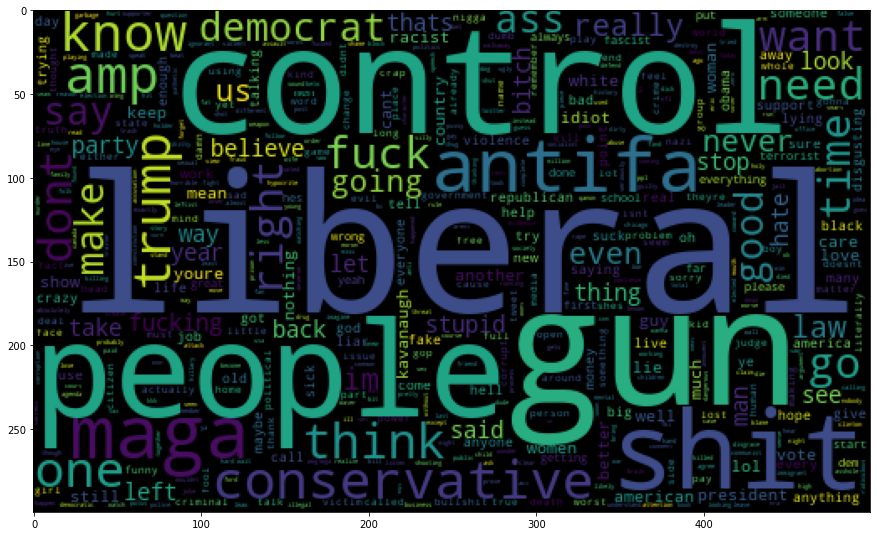

In [41]:
from wordcloud import WordCloud

######### offensive
data_offensive = df[-1][df[-1]['label'] == 1]
data_not_offensive = df[-1][df[-1]['label'] == 0]

plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 1000 , width = 500 , height = 300,
               collocations=False).generate(" ".join(data_offensive['text']))
plt.imshow(wc)

Now we see the most common words in another subset: stance_abortion, with help of Counter.

As we can see, some words like "semst" don't seem to be right. If we look back into data we find out this is the hashtag which could be a short term of something trended at the time so this also can be included in stopwords but it also shows the bias of tweets about specific topic at the time.

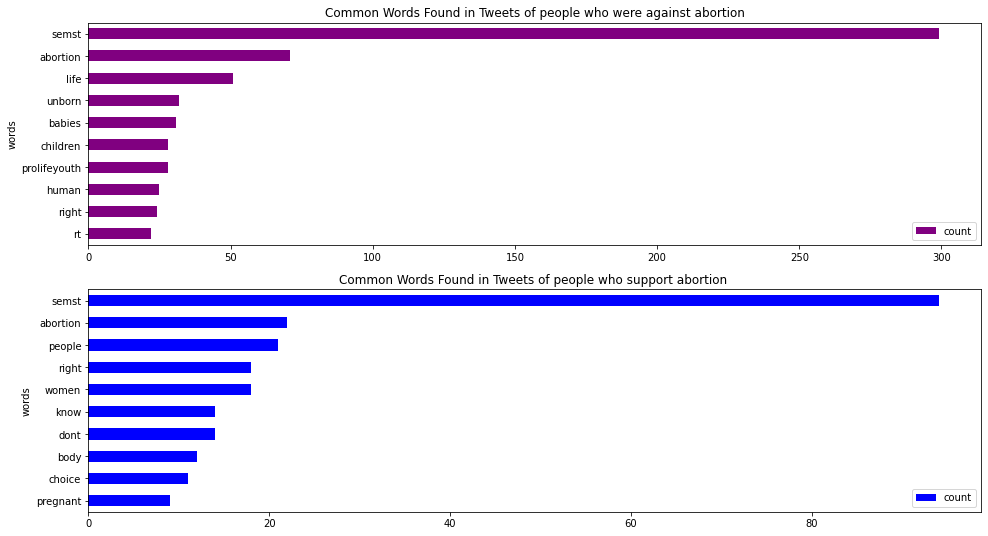

In [74]:
######### abortion 
from collections import Counter
common_words = Counter(" ".join(df[1][df[1]['label'] == 1]['text']).split()).most_common(10)
most_common_against_abortion = pd.DataFrame(common_words,columns=['words', 'count'])
common_words = Counter(" ".join(df[1][df[1]['label'] == 2]['text']).split()).most_common(10)
most_common_favor_abortion = pd.DataFrame(common_words,columns=['words', 'count'])

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,9))

# Plot horizontal bar graph
most_common_against_abortion.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax1,
                      color="purple")
most_common_favor_abortion.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax2,
                      color="blue")


ax1.set_title("Common Words Found in Tweets of people who were against abortion")
ax2.set_title("Common Words Found in Tweets of people who support abortion ")

plt.show()

# Polarity and Subjectivity


Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion,  emotion or judgment whereas objective refers to factual information.Subjectivity is also a float which lies in the range of [0,1]. Here , I chose emotion subset of dataset to examine the polarity of data. labels are as following : 


0: anger

1: joy

2: optimism

3: sadness

We can see from the histogram that sentiments are mostly focused on neutral and negative part of axis and very less on positive , which makes sense because people are not nice when they're angry!

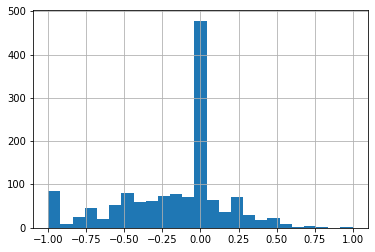

In [103]:

from textblob import TextBlob
anger = df[2][df[2]['label']==0]['text']
polarity_anger = anger.apply(lambda x : TextBlob(x).sentiment.polarity)
# anger_pd= pd.concat([anger,anger.apply(lambda x : TextBlob(x).sentiment.polarity)],axis=1 )
polarity_anger.hist(bins=25)

We can have same observation for other emotions too.

Text(0.5, 0.04, 'Polarity')

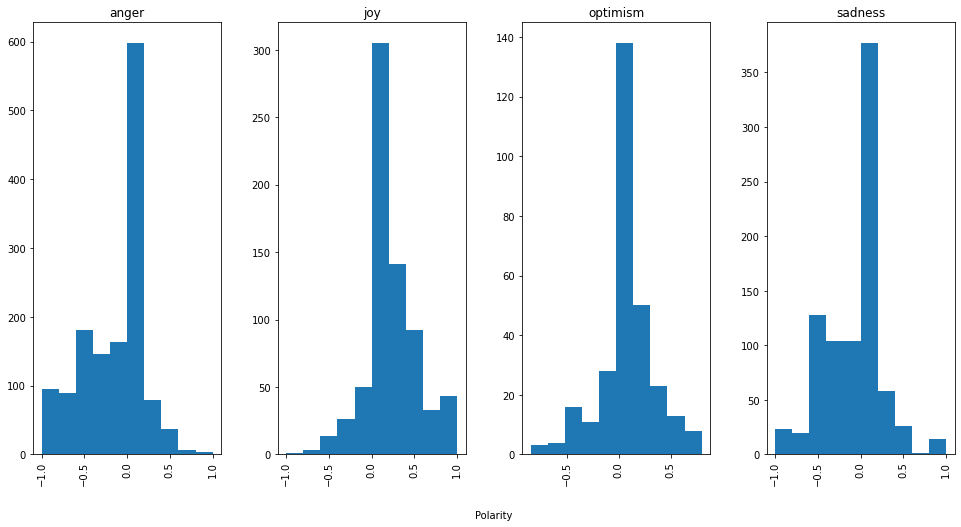

In [145]:
from matplotlib import figure
df[2]['polarity'] = df[2]['text'].apply(lambda x : TextBlob(x).sentiment.polarity)
df[2]['label'] = df[2]['label'].map({0:'anger', 1:'joy', 2:'optimism', 3:'sadness' })
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(16,8))
df[2].hist(column='polarity',by='label', ax=axes)
# plt.suptitle('Your Title Here', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Polarity', ha='center')

  

Same for subjectivity, we can observe from histograms that tweets that are categorized based on emotion were mostly based on public opinion not a personal.

Text(0.5, 0.04, 'Subjectivity')

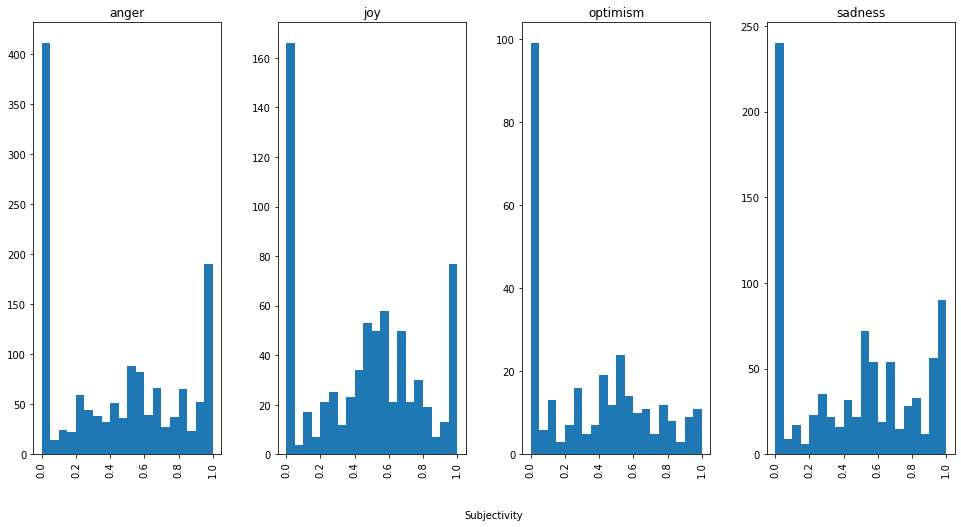

In [147]:
df[2]['subjectivity'] = df[2]['text'].apply(lambda x : TextBlob(x).sentiment.subjectivity)
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(16,8))
df[2].hist(column='subjectivity',by='label', ax=axes, bins=20)
# plt.suptitle('Your Title Here', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Subjectivity', ha='center')
